# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib torch torchvision tqdm
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

import string
# characters = '-' + string.digits + string.ascii_uppercase
characters= string.digits
width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

0123456789 192 64 4 10


# 搭建数据集

In [2]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

# 测试数据集

7373 tensor([12]) tensor([4])


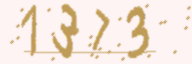

In [3]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

# 初始化数据集生成器

In [4]:
# batch_size = 128
batch_size =1
# train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
# valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)
# 如果num_workers用12，出现DataLoader worker exited unexpectedly

train_set = CaptchaDataset(characters, 2 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 2 * batch_size, width, height, n_input_length, n_len)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=0)

# 搭建模型

In [5]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## 测试模型输出尺寸

In [6]:
model = Model(n_classes, input_shape=(3, height, width))
# inputs = torch.zeros((32, 3, height, width))

inputs = torch.zeros((8, 3, height, width))

outputs = model(inputs)
outputs.shape

torch.Size([12, 8, 10])

## 初始化模型

In [7]:
torch.cuda.empty_cache()
print(n_classes)

10


In [8]:
torch.backends.cudnn.enabled = False

model = Model(n_classes, input_shape=(3, height, width))
model = model.cuda()
model

RuntimeError: CUDA error: out of memory

In [9]:
torch.cuda.empty_cache()

# 解码函数和准确率计算函数

In [10]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

# 训练模型

In [11]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [12]:
# gpu_options.allow_growth = True 

# GPU测试
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

print(torch.__version__)
#torch.cuda.is_available()还不能充分证明你能使用cuda
torch.randn(4,4,4).cuda().mean()

torch.cuda.memory_summary(device=None, abbreviated=False)

cuda
1.7.0a0+6324ef4


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 0 bytes already allocated; 0 bytes free; 0 bytes reserved in total by PyTorch)

In [13]:
# import GPUtil

# out = model(input)
# GPUtil.showUtilization()
# watch -n 0.1 nvidia-smi

In [20]:
# with torch.no_grad():
# torch.cuda.clear_memory_allocated()
# torch.utils.checkpoint

# CUDA_VISIBLE_DEVICES="1"  

# optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-1, amsgrad=False)

# optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)

# optimizer = torch.optim.Adam(model.parameters(), 1e-1, amsgrad=True)

# train_loader.cuda()
# tqdm(optimizer).data.cuda()
# epochs = 30
epochs =1
# print(train_loader)
# train(model, optimizer, 1, train_loader)
# with torch.no_grad():
    # torch.cuda.empty_cache()
# for epoch in range(1, epochs + 1):
#     train(model, optimizer, epoch, train_loader)
    # valid(model, optimizer, epoch, valid_loader)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

0%|          | 0/2 [00:00<?, ?it/s]

# 测试模型输出

true: DYE8
pred: DYE8
true: BMRV
pred: BMRV
true: 9NPM
pred: 9NPM
true: CCVM
pred: CCVM
true: QN7Z
pred: QN7Z
true: PGK1
pred: PGK1
true: 4SIU
pred: 4SIU
true: A662
pred: A662
true: KLUM
pred: KLUM
true: NOFK
pred: NOFK
true: MAIR
pred: MAIR
true: BOXU
pred: BOXU
true: OA18
pred: OA18
true: FQEK
pred: FQEK
true: UIED
pred: UIED
true: Y4MR
pred: Y4MR
true: SZXQ
pred: SZXQ
true: 5OND
pred: 5OND
true: 3HEP
pred: 3HEP
true: IKJ8
pred: IKJ8
true: LTWA
pred: LTWA
true: K5O7
pred: K5O7
true: 4R71
pred: 4R71
true: JL3Z
pred: JL3Z
true: ER9Z
pred: ER9Z
true: EZ1S
pred: EZ1S
true: EGKF
pred: EGKF
true: XF0X
pred: XF0X
true: Z8P4
pred: Z8P4
true: ADCK
pred: ADCK
true: B1K0
pred: B1K0
true: D8KG
pred: D8KG
true: XPTH
pred: XPTH
true: T1ZY
pred: T1ZY
true: 8WG5
pred: 8WG5
true: P7RV
pred: P7RV
true: 0HLH
pred: 0HLH
true: U0AG
pred: U0AG
true: 56PK
pred: 56PK
true: 6IJG
pred: 6IJG
true: 2FN2
pred: 2FN2
true: 7QNI
pred: 7QNI
true: OKZH
pred: OKZH
true: 1DI8
pred: 1DI8
true: 62T2
pred: 62T2
true: 85ET

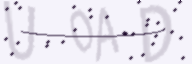

In [13]:
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

In [14]:
torch.save(model, 'ctc.pth')

/home/ypw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
